<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/main/assignments/GIS5122_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3
**Due date/time:** Mar 6th Wed 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A3_your_name.ipynb on Canvas.

## Detailed instructions:

In this assignment, we will practie on model selection and spatial autocorrelation.

**Note**: From this assignment and onward, if you are interested in performing your analysis using your own data (e.g., you may have a dataset from a research project), you are very encouraged to do so.

We will be re-using our county-level health data `health` obtained from [CDC](https://www.cdc.gov/places/index.html) to investigate [Social Determinants of Health](https://www.cdc.gov/about/sdoh/index.html). You can find the explanations to the columns in the data [here](https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/cdc_county_health.txt).

You are also given a county-level socio-demographic dataset `socio_demo` obtaiend from the American Community Survey (2015-2019) dataset. Variable name explanations can be seen [here](https://github.com/Ziqi-Li/GIS5122/blob/main/data/acs_2019_variables.txt).

The objective is to identify socio-demographic factors that will explain health outcome inequality in the US, by estimating a regression model.

You are also given a county-level boundary file `counties` for making necessary maps.

Below are specific tasks you need to perform and their credits (total 100%):
1. Create a `GeoDataFrame` by merging the `health`, the `socio_demo` and the `counties` boundary together. Code is given.
2. Choose **ONE** health outcome of your interest. Make a map of the health outcome to show its spatial distribution. (**5%**)
3. Build a linear regression model (OLS) with the health outcome as the dependent variable, and socio-demographic variables as the independent variables. You are supposed to tweak the model specification based on your own understanding of the potential relationships. Optionally but not required, you can use the forward/backward/stepwise selection code (autoselect.py) to help you decide which predictors you want to include in your model. Report and interpret your linear regression results regarding your model R2, regression coefficients, and statistical significance of the coefficients. (**30%**)
5. Create a residual vs fit plot and a Q-Q plot to check the model residual assumptions. Describe whether the patterns in these plots noticeably violate any of the LINE regression assumptions. In this speficic assignment, you are only expected to diagnose issues but you don't need to fix the issues. (**10%**)
6. Make a map of the residuals to examine spatial autocorrelation. Then compute Moran's I value of the residuals based on Queen-contiguity spatial weights matrix. Interpret the Moran's I value and its statistical significance. (**15%**)
7. Fit both a spatial lag model and a spatial error model and cross compare all three methods (slm, sem, ols) and indicate which model we should use based on the evidence from 1) AIC; 2) L-M test and 3) residual spatial autocorrelation. (**40%**)



You may need to install these two packages:

In [1]:
pip install -q libpysal

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q splot

Note: you may need to restart the kernel to use updated packages.


In [3]:
from autoselect import *

Import all the packages needed to run the analysis

In [4]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from libpysal.weights import Queen
from splot.esda import plot_moran
from esda.moran import Moran
import spreg

Code to read in data and merge them into one final `GeoDataFrame`.

In [5]:
health_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/cdc_health_county.csv"
health = pd.read_csv(health_url)

In [6]:
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [7]:
counties_url = "https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson"
counties = gpd.read_file(counties_url)

In [8]:
income_health = pd.merge(socio_demo, health, left_on = "county_id", right_on = "LocationID")

In [9]:
gdf_income_health = pd.merge(counties, income_health, on = "county_id")

Your code will start here, and your analysis will be based on this GeoDataFrame `gdf_income_health`.

# Choose ONE health outcome of your interest. Make a map of the health outcome to show its spatial distribution. (5%)

In [41]:
gdf_income_health.head()

,GEOID,STATEFP,NAME_x,county_id,geometry,state,county,NAME_y,proj_X,proj_Y,...,DIABETES,KIDNEY,LPA,MAMMOUSE,MHLTH,OBESITY,PHLTH,SLEEP,STROKE,TEETHLOST
0,37017,37,Bladen,37017,"POLYGON ((1542624.56400 1447518.25861, 1551448...",37,17,"Bladen County, North Carolina",1.577416e+06,1428761.544,...,14.1,3.6,30.8,74.4,17.2,40.8,16.0,38.8,4.5,24.6
1,37167,37,Stanly,37167,"POLYGON ((1393365.57999 1463317.09569, 1405814...",37,167,"Stanly County, North Carolina",1.413288e+06,1479060.274,...,10.5,2.8,25.8,73.2,15.4,33.2,13.3,36.5,3.4,17.9
2,39153,39,Summit,39153,"POLYGON ((1187539.95372 2103811.07817, 1185335...",39,153,"Summit County, Ohio",1.200457e+06,2104620.320,...,10.7,2.7,24.4,70.9,15.0,33.1,12.2,38.6,3.1,15.1
3,42113,42,Sullivan,42113,"POLYGON ((1576879.76977 2224763.14827, 1626097...",42,113,"Sullivan County, Pennsylvania",1.604589e+06,2214031.262,...,9.7,2.7,24.9,70.4,16.4,34.8,13.4,39.5,3.2,17.5
4,48459,48,Upshur,48459,"POLYGON ((79020.44409 1065817.40446, 78838.627...",48,459,"Upshur County, Texas",9.865517e+04,1074469.576,...,10.8,2.9,27.1,69.1,15.4,35.4,13.5,37.0,3.4,17.0


Text(0.5, 1.0, 'Spatial Distribution of Obesity among adults aged 18 and above')

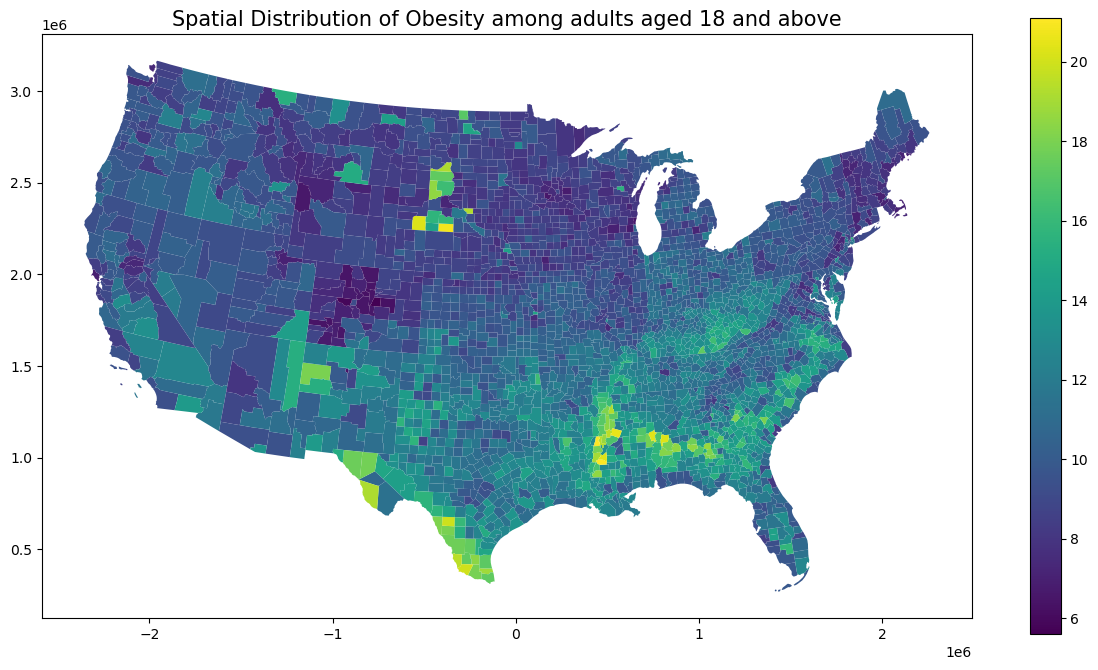

In [11]:
ax = gdf_income_health.plot(column='DIABETES',legend=True,
                                                figsize=(15,8), linewidth=0.0,aspect=1)
plt.title("Spatial Distribution of Obesity among adults aged 18 and above",fontsize=15)

# Build a linear regression model (OLS) with the health outcome as the dependent variable, and socio-demographic variables as the independent variables.

In [12]:
socio_demo.head()

,county_id,state,county,NAME,proj_X,proj_Y,total_pop,sex_ratio,pct_black,pct_hisp,pct_bach,median_income,pct_65_over,pct_age_18_29,gini,pct_manuf,ln_pop_den,pct_fb,pct_uninsured
0,17051,17,51,"Fayette County, Illinois",597979.5531,1796861.993,21565,113.6,4.7,1.9,11.3,46650,18.8,14.899142,0.4373,14.9,3.392715,1.3,8.2
1,17107,17,107,"Logan County, Illinois",559814.6766,1920479.975,29003,97.2,6.9,3.4,19.9,57308,18.0,17.256836,0.4201,12.4,3.847224,1.6,4.5
2,17165,17,165,"Saline County, Illinois",650278.3579,1660709.808,23994,96.9,2.6,1.8,19.2,44090,19.9,13.586730,0.4692,8.7,4.128654,1.0,4.2
3,17097,17,97,"Lake County, Illinois",654010.9262,2174576.605,701473,99.8,6.8,21.7,45.3,89427,13.7,15.823132,0.4847,16.3,7.308201,18.7,6.8
4,17127,17,127,"Massac County, Illinois",640398.9863,1599902.491,14219,89.5,5.8,2.9,13.9,47481,20.8,12.370772,0.4097,7.4,4.067788,1.0,5.4


In [42]:
y_name = 'OBESITY'
X_names =['median_income', 'pct_black', 'pct_hisp', 'pct_bach', 'sex_ratio', 'pct_65_over', 'pct_age_18_29', 'gini', 'pct_manuf','ln_pop_den', 'pct_fb', 'pct_uninsured']

# Backward search Model selection Method
backward_model_selection(y_name, X_names, gdf_income_health)


Current model: OBESITY ~ intercept + median_income + pct_black + pct_hisp + pct_bach + sex_ratio + pct_65_over + pct_age_18_29 + gini + pct_manuf + ln_pop_den + pct_fb + pct_uninsured
        current    15415.58
-  median_income    15454.44
-     pct_black    15675.23
-      pct_hisp    15435.77
-      pct_bach    15855.16
-     sex_ratio    15441.79
-   pct_65_over    15478.57
-  pct_age_18_29     15428.4
-          gini    15414.84
-     pct_manuf    15416.92
-    ln_pop_den    15416.36
-        pct_fb    15477.22
-  pct_uninsured     15413.7
dropping  pct_uninsured

Current model: OBESITY ~ intercept + median_income + pct_black + pct_hisp + pct_bach + sex_ratio + pct_65_over + pct_age_18_29 + gini + pct_manuf + ln_pop_den + pct_fb
        current     15413.7
-  median_income    15454.31
-     pct_black    15677.44
-      pct_hisp    15435.09
-      pct_bach    15860.72
-     sex_ratio    15440.47
-   pct_65_over    15480.96
-  pct_age_18_29     15426.4
-          gini    15413.03
-

In [43]:
y = gdf_income_health['OBESITY']
x =gdf_income_health[['median_income', 'pct_black', 'pct_bach', 'sex_ratio', 'pct_65_over', 'pct_age_18_29', 'ln_pop_den' ]]

x= sm.add_constant(x)

best_model=sm.OLS(y,x).fit()


In [44]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                OBESITY   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     599.3
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:54:36   Log-Likelihood:                -7730.1
No. Observations:                3103   AIC:                         1.548e+04
Df Residuals:                    3095   BIC:                         1.552e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            48.7584      0.842     57.931      0.000      47.108      50.409
median_income -6.069e-05   6.95e-06     -8.731      0.000   -7.43e-05   -4.71e-05
pct_black         0.0681      0.004     16.652      0.000       0.060       0.076
pct_bach         -0.2585      0.010    -26.398      0.000      -0.278      -0.239
sex_ratio        -0.0335      0.005     -6.362      0.000      -0.044      -0.023
pct_65_over      -0.1364      0.017     -8.059      0.000      -0.170      -0.103
pct_age_18_29     0.0806      0.020      4.045      0.000       0.042       0.120
ln_pop_den       -0.1338      0.040     -3.313      0.001      -0.213      -0.055
==============================================================================
Omnibus:                       26.933   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.028
Skew:                          -0.191   Prob(JB):                     4.97e-07
Kurtosis:                       3.280   Cond. No.                     8.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation

R-squared: The R-squared value of 0.575 indicates that approximately 57.5% of the variance in the obesity rates can be explained by the socio-demographic variables included in the model. This suggests a moderate level of explanatory power.

Adjusted R-squared: With a value very close to the R-squared (0.574), it confirms that the model's explanatory power remains robust even after adjusting for the number of predictors.

F-statistic (599.3) with a Prob (F-statistic) of 0.00: This indicates that the overall regression model is statistically significant at conventional significance levels. The very low p-value (close to 0) suggests that it is extremely unlikely that the observed relationship between the independent variables and obesity rates is due to chance.


### Coefficients and Their Significance

Constant (Intercept) = 48.7584: When all independent variables are zero, the obesity rate is expected to be approximately 48.76%.

Median Income (coef = -6.069e-05): For every one-unit increase in median income, the obesity rate is expected to decrease by 0.006069%. This suggests a very small but statistically significant negative relationship between median income and obesity rates, indicating that higher income levels might be associated with slightly lower obesity rates.

Percentage of Black Population (pct_black, coef = 0.0681): A one-percentage-point increase in the black population is associated with a 0.0681% increase in the obesity rate. This positive coefficient indicates a statistically significant relationship where areas with a higher percentage of the black population might see slightly higher obesity rates.

Percentage with Bachelor’s Degrees (pct_bach, coef = -0.2585): For every one-percentage-point increase in the population with bachelor’s degrees, the obesity rate is expected to decrease by 0.2585%. This significant negative coefficient suggests that higher education levels are associated with lower obesity rates, potentially due to factors like increased health awareness, better economic conditions, and access to healthier lifestyles.

Sex Ratio (sex_ratio, coef = -0.0335): A one-unit increase in the sex ratio is associated with a 0.0335% decrease in the obesity rate. Assuming sex ratio measures the number of males per hundred females, this indicates that higher proportions of males in the population are associated with slightly lower obesity rates.This relationship is statistically significant

Percentage of Population Over 65 (pct_65_over, coef = -0.1364): A one-percentage-point increase in the population aged 65 and over is associated with a 0.1364% decrease in the obesity rate. This suggests that areas with older populations tend to have lower obesity rates, possibly due to differences in lifestyle or physiological factors associated with age.This relationship is statistically significant

Percentage of Population Aged 18 to 29 (pct_age_18_29, coef = 0.0806): A one-percentage-point increase in the population aged 18 to 29 is associated with a 0.0806% increase in the obesity rate. This indicates that areas with a higher proportion of young adults may see slightly higher obesity rates.This relationship is statistically significant

Natural Log of Population Density (ln_pop_den, coef = -0.1338): A one-unit increase in the natural logarithm of population density is associated with a 0.1338% decrease in the obesity rate. This suggests that more densely populated areas tend to have lower obesity rates. This relationship is statistically significant.

# Create a residual vs fit plot and a Q-Q plot to check the model residual assumptions

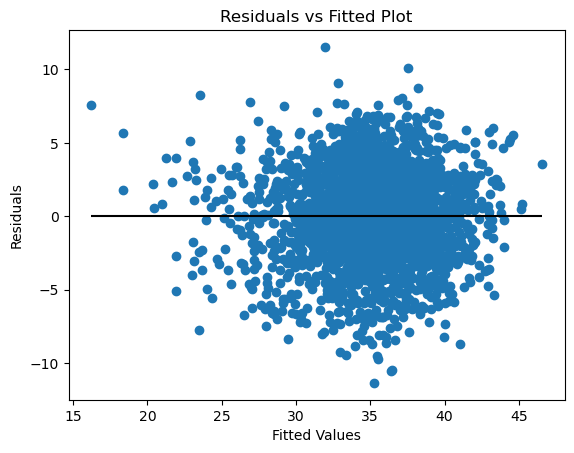

In [47]:
fitted_values = best_model.predict()
residuals = best_model.resid

plt.scatter(fitted_values, residuals)
plt.hlines(y=0, xmin=min(fitted_values), xmax=max(fitted_values), color="black")
plt.title("Residuals vs Fitted Plot")
plt.xlabel("Fitted Values")  
plt.ylabel("Residuals") 
plt.show()


The residuals vs. fitted plot reveals a distinctive pattern where the spread of residuals increases with the fitted values, suggesting a violation of the homoscedasticity assumption, which expects equal variance across the range of fitted values. This phenomenon, known as heteroscedasticity, implies that the variance of the residuals is not constant and points towards potential issues with using a simple linear model for this data. 


In this plot, there is a noticeable pattern where the residuals seem to fan out as the fitted values increase, which suggests that the relationship might not be linear.

In [49]:
def q_q_plot(res):
    fig, axes =plt.subplots(1,2, figsize=(12,4))
    res.hist(ax=axes[0])
    sm.qqplot(res, line= "q", ax=axes[1])

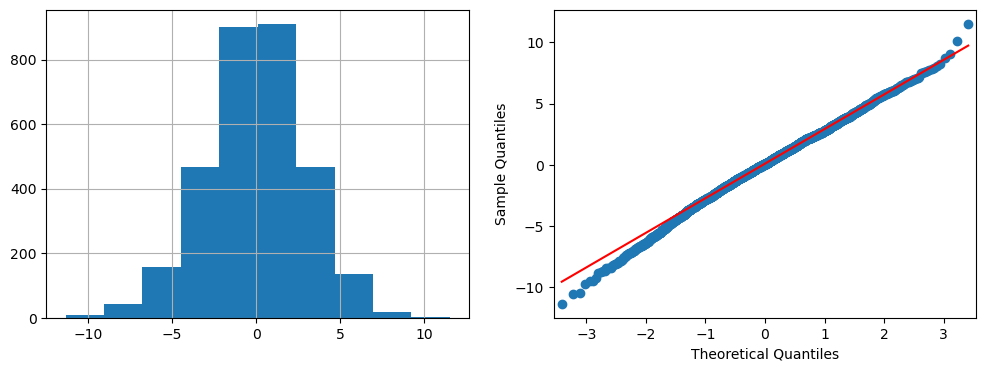

In [50]:
q_q_plot(best_model.resid)

Our histogram reveals a generally symmetric and mound-shaped distribution, hinting at an approximately normal distribution of residuals, despite a subtle suggestion of bimodality that could challenge the normality assumption.



The Q-Q plot you provided shows that most points fall along the reference line, but there are some deviations at the ends.
The slight deviation at the tails could indicate that the residuals have heavier tails than the normal distribution (leptokurtosis). This would be a violation of the normality assumption.

# Make a map of the residuals to examine spatial autocorrelation. Then compute Moran's I value of the residuals based on Queen-contiguity spatial weights matrix. Interpret the Moran's I value and its statistical significance

In [52]:
##y = gdf_income_health['OBESITY']
variable_names =['median_income', 'pct_black', 'pct_bach', 'sex_ratio', 'pct_65_over', 'pct_age_18_29', 'ln_pop_den']


y = gdf_income_health[['OBESITY']].values

X = gdf_income_health[variable_names].values

In [53]:
ols = spreg.OLS(y, X, name_y='OBESITY', name_x=variable_names)

In [54]:
print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           8
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3095
R-squared           :      0.5754
Adjusted R-squared  :      0.5745
Sum squared residual:     26492.5                F-statistic           :    599.2890
Sigma-square        :       8.560                Prob(F-statistic)     :           0
S.E. of regression  :       2.926                Log likelihood        :   -7730.146
Sigma-square ML     :       8.538                Akaike info criterion :   15476.292
S.E of regression ML:      2.9219                Schwarz criterion     :   15524.613

------------------------------------------------------------

In [55]:
ols.u

array([[ 1.34351197],
       [-3.30802012],
       [ 0.46042226],
       ...,
       [ 3.62530451],
       [-2.64865495],
       [-2.75224206]])

Text(0.5, 1.0, 'Map of residuals of the OLS model')

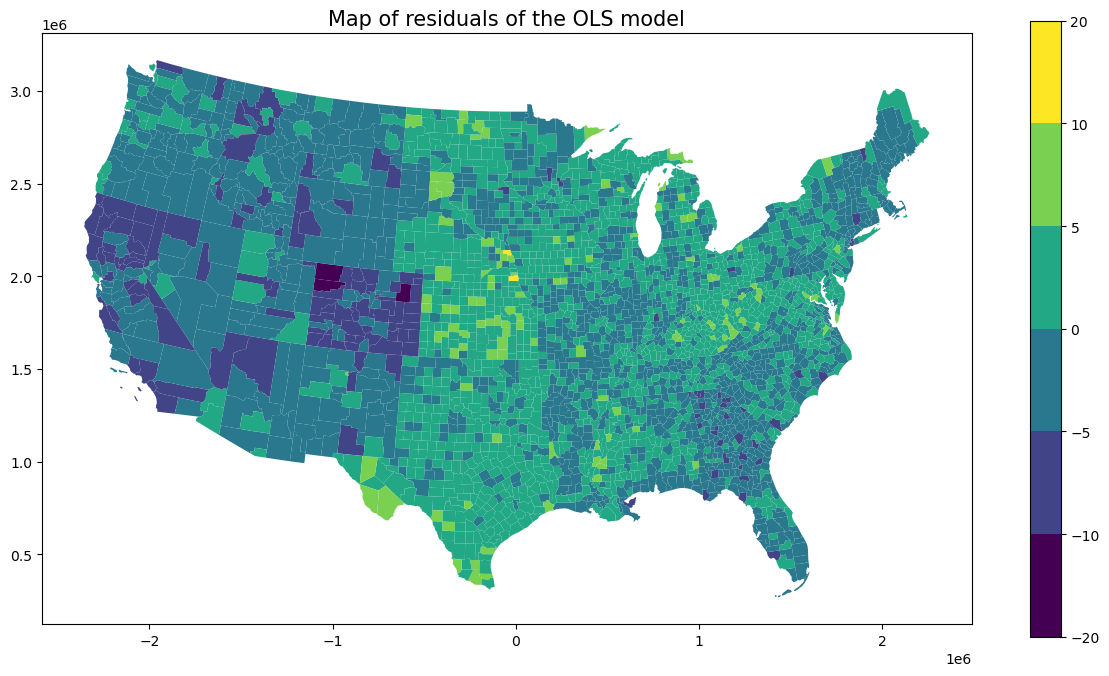

In [56]:
from matplotlib import colors

#For creating a discrete color classification
norm = colors.BoundaryNorm([-20, -10, -5, 0, 5, 10, 20],ncolors=256)

ax = gdf_income_health.plot(column=ols.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)


plt.title("Map of residuals of the OLS model",fontsize=15)

In [57]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'


C:\Users\jacob\AppData\Local\Temp\ipykernel_15004\2081773674.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


C:\Users\jacob\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


C:\Users\jacob\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.48', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.48)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

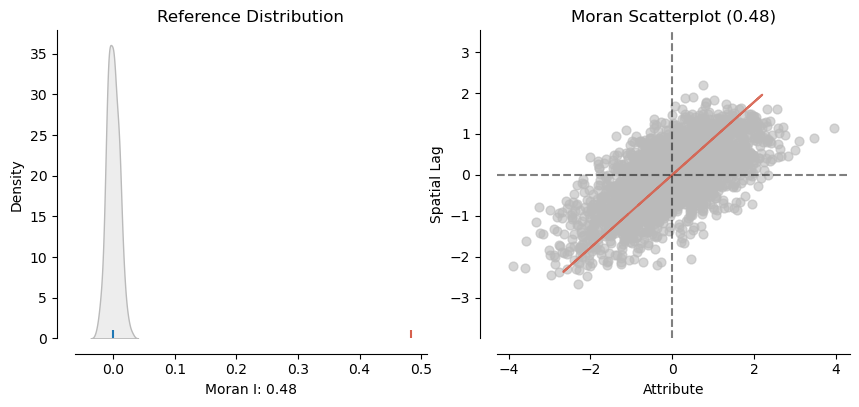

In [58]:
#Here, lets calculate the Moran's I value, and plot it.
#ols.u is the residuals from the OLS model

ols_moran = Moran(ols.u, w, permutations = 199) #199 permutations

plot_moran(ols_moran, figsize=(10,4))

The observed value of Moran's I at 0.48 indicates a moderate positive spatial autocorrelation, and the position of this value in the reference distribution suggests that this is statistically significant, meaning that the observed spatial pattern is unlikely to have arisen from random chance.

# Fit both a spatial lag model and a spatial error model and cross compare all three methods (slm, sem, ols) and indicate which model we should use based on the evidence from 1) AIC; 2) L-M test and 3) residual spatial autocorrelation.

### OLS Model

In [59]:
ols = spreg.OLS(y, X, w=w, spat_diag=True, moran=True,
                name_y='OBESITY', name_x=variable_names)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           8
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3095
R-squared           :      0.5754
Adjusted R-squared  :      0.5745
Sum squared residual:     26492.5                F-statistic           :    599.2890
Sigma-square        :       8.560                Prob(F-statistic)     :           0
S.E. of regression  :       2.926                Log likelihood        :   -7730.146
Sigma-square ML     :       8.538                Akaike info criterion :   15476.292
S.E of regression ML:      2.9219                Schwarz criterion     :   15524.613

------------------------------------------------------------

### Sem Model

In [60]:
sem = spreg.ML_Error(y, X, w=w, name_x=variable_names, name_y='OBESITY')

print(sem.summary)

C:\Users\jacob\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           8
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3095
Pseudo R-squared    :      0.5645
Log likelihood      :  -7039.1376
Sigma-square ML     :      4.8816                Akaike info criterion :   14094.275
S.E of regression   :      2.2094                Schwarz criterion     :   14142.596

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        46.55008    

In [62]:
sem.e_filtered

array([[ 2.87598969],
       [-2.34207904],
       [-0.7712344 ],
       ...,
       [ 1.1974435 ],
       [-0.90541475],
       [-0.60860018]])

C:\Users\jacob\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.06', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (-0.06)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

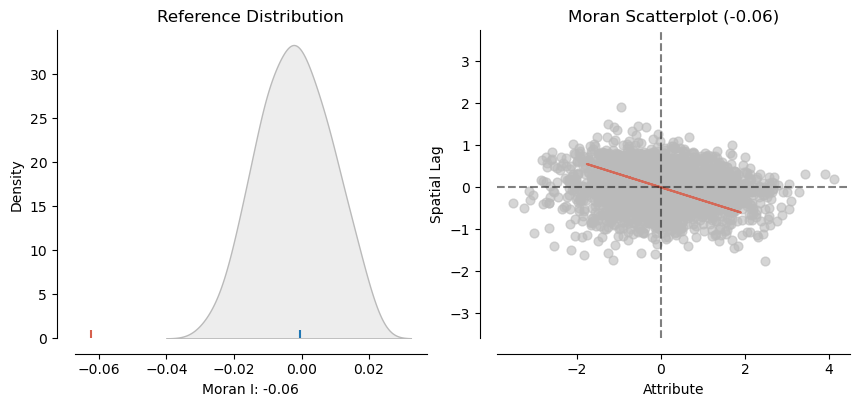

In [63]:
sem_moran = Moran(sem.e_filtered, w, permutations = 199) #199 permutations
plot_moran(sem_moran, zstandard=True, figsize=(10,4))

Text(0.5, 1.0, 'Map of filtered residuals of the SEM model')

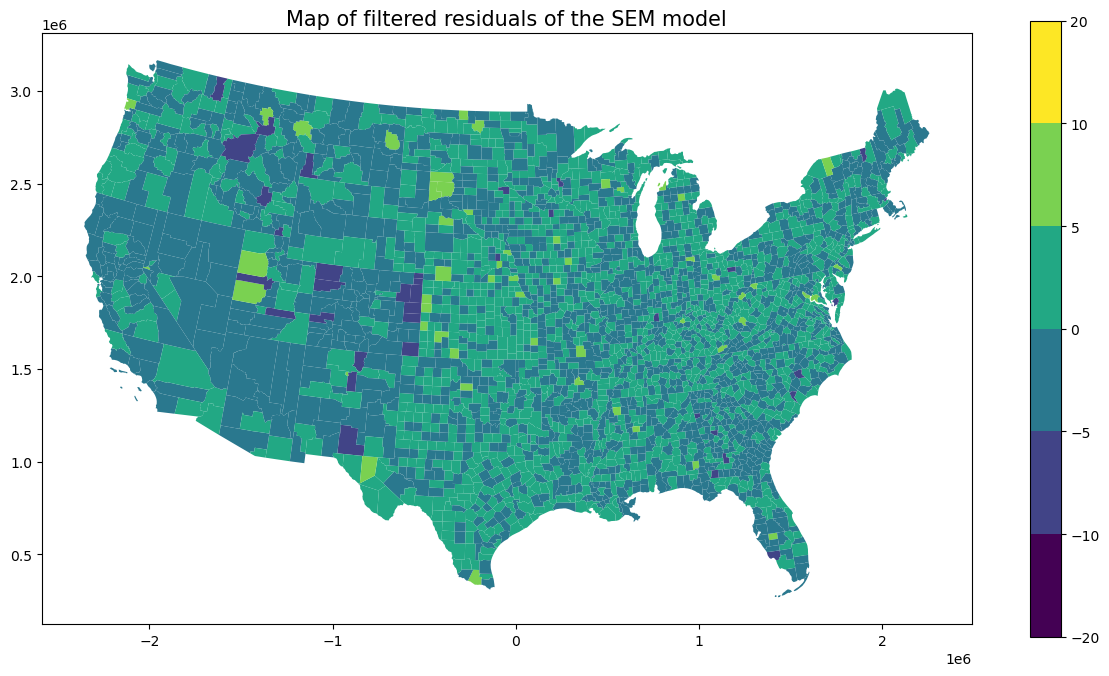

In [64]:
ax = gdf_income_health.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

plt.title("Map of filtered residuals of the SEM model",fontsize=15)

### SLM Model

In [65]:
slm = spreg.ML_Lag(y, X, w=w, name_y='OBESITY', name_x=variable_names)

print(slm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     OBESITY                Number of Observations:        3103
Mean dependent var  :     35.2209                Number of Variables   :           9
S.D. dependent var  :      4.4851                Degrees of Freedom    :        3094
Pseudo R-squared    :      0.6991
Spatial Pseudo R-squared:  0.5628
Log likelihood      :  -7267.0889
Sigma-square ML     :      6.0575                Akaike info criterion :   14552.178
S.E of regression   :      2.4612                Schwarz criterion     :   14606.539

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

C:\Users\jacob\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.1', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.1)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

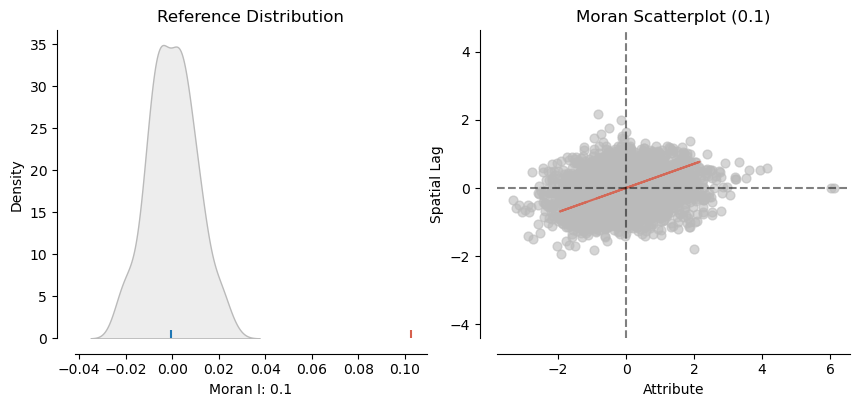

In [67]:
slm_moran = Moran(slm.u, w, permutations = 199) #199 permutations
plot_moran(slm_moran, zstandard=True, figsize=(10,4))

Text(0.5, 1.0, 'Map of residuals of the spatial lag model')

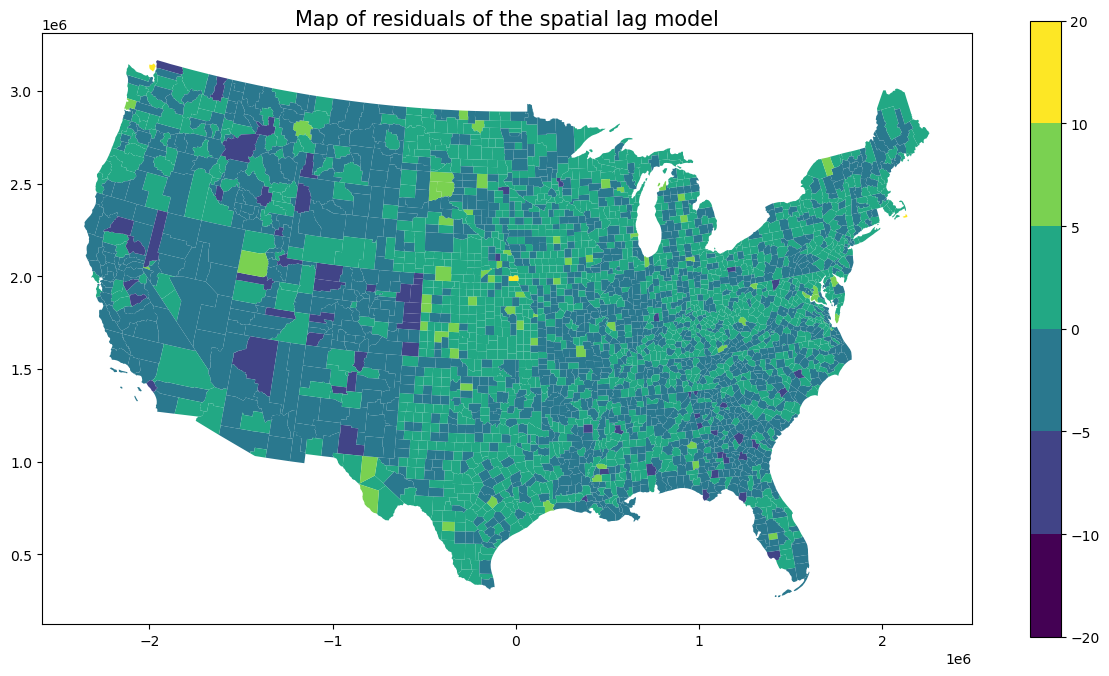

In [68]:
ax = gdf_income_health.plot(column=slm.u.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)

plt.title("Map of residuals of the spatial lag model",fontsize=15)

# Cross-comparison of Lag, Error and OLS models

| Parameter              | OLS Estimates   | SLM Estimates   | SEM Estimates|
| --------------------   | -----------     | -----------     | -----------  |
| AIC                    | 15476.29        | 14552.18        | 14094.28     |
| Moran's I of residuals | 0.48            | 0.10            | -0.06        |


## *Lagrange Multiplier (L-M) test:*

Lagrange Multiplier (lag) for OLS: 1203.537 (P-value: 0.0000)

Lagrange Multiplier (error) for OLS: 2024.895 (P-value: 0.0000)



Based on the evidence above, it sugguest that the SEM not only has the lowest AIC, indicating it provides a better fit with less complexity but also effectively addresses spatial autocorrelation in the residuals (Moran's I = -0.06). This suggests the SEM is  the most suitable model for this data, taking into account both the model fit and its ability to handle spatial dependencies.

Therefore, I will use the error model among the three models based on the provided evidence.
